# Notebook for model training

Trains streaming pre-downloaded raster data on disk. Expected data folder structure:

```
training_patches/
├── train/
│   ├── 0/
│   └── 1/
└── val/
    ├── 0/
    └── 1/
```

In [2]:
from datetime import date
import glob
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import rasterio
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from scripts import dl_utils
from scripts import viz_tools

WORK_DIR = '..'

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [22]:

augmentation_parameters = {
    'featurewise_center': False,
    'rotation_range': 360,
    'width_shift_range': 0.1,   # fractional shift in Keras, not scaling
    'height_shift_range': 0.1,
    'shear_range': 10,
    'zoom_range': [0.9, 1.1],
    'vertical_flip': True,
    'horizontal_flip': True,
    'fill_mode': 'reflect'
}

def sat_batch_generator(data_dir, aug_generator=None, batch_size=8, shuffle=True):
    """
    Streams batches of image data from subdirectories '0' (negatives) and '1' (positives) and optionally
    applies ImageDataGenerator augmentation.
    """
    files_class_0 = glob.glob(os.path.join(data_dir, '0', '*.tif'))
    files_class_1 = glob.glob(os.path.join(data_dir, '1', '*.tif'))
    files = files_class_0 + files_class_1

    if not files:
        raise FileNotFoundError(f"No .tif files found in '0' or '1' subdirectories of {data_dir}")

    while True:
        if shuffle:
            random.shuffle(files)

        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            imgs, labels = [], []

            for file_path in batch_files:
                with rasterio.open(file_path) as src:
                    arr = src.read()  # (bands, height, width)
                    arr = np.moveaxis(arr, 0, -1)  # (H, W, C)
                    arr = arr.astype(np.float32) / 10000.0
                    imgs.append(arr)

                # Get the label from the parent directory name ('0' or '1')
                try:
                    label_str = os.path.basename(os.path.dirname(file_path))
                    labels.append(int(label_str))
                except (ValueError, TypeError):
                    raise ValueError(
                        f"Could not determine label from directory for file: {file_path}. "
                        f"Ensure it is in a subdirectory named '0' or '1'."
                    )

            batch_images = np.stack(imgs, axis=0)
            batch_labels = np.array(labels, dtype=np.int64)

            if aug_generator:
                aug_iter = aug_generator.flow(batch_images, batch_labels, batch_size=batch_size, shuffle=False)
                images, labels = next(aug_iter)
            else:
                images = batch_images
                labels = batch_labels
                
            yield images, labels


## Train Model

In [31]:
num_classes = 2
input_shape = (48, 48, 13)
print("Input Shape:", input_shape)

Input Shape: (224, 224, 12)


In [32]:
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.MaxPooling2D(pool_size=(3)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(3e-4), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy(name="acc")])

train_accuracy = []
test_accuracy = []

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      3488      
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 32)      9248      
                                                      

In [1]:
data_dir = os.path.join(WORK_DIR, 'data/training_patches')

positive_paths =  glob.glob(f"{data_dir}/train/1/*.tif")
negative_paths = glob.glob(f"{data_dir}/train/0/*.tif")
pos_val_paths = glob.glob(f"{data_dir}/val/1/*.tif")
neg_val_paths = glob.glob(f"{data_dir}/val/0/*.tif")
print(f"{len(positive_paths)} train positives")
print(f"{len(negative_paths)} train negatives")
print(f"{len(pos_val_paths)} val positives")
print(f"{len(neg_val_paths)} val negatives")

NameError: name 'os' is not defined

In [12]:
# Calibrate steps per epoch x batch size to equal or exceed the total number of training samples. 

batch_size = 32
total_training_samples = len(positive_paths) + len(negative_paths)
print(f"suggested steps per epoch {math.ceil(total_training_samples / batch_size)}")

total_val_samples = len(pos_val_paths) + len(neg_val_paths)
print(f"suggested validation steps {math.ceil(total_val_samples / batch_size)}")

suggested steps per epoch 94
suggested validation steps 25


In [51]:
aug_generator = ImageDataGenerator(**augmentation_parameters)
train_gen = sat_batch_generator(os.path.join(data_dir, 'train'), aug_generator, batch_size=batch_size, shuffle=True)
val_gen = sat_batch_generator(os.path.join(data_dir, 'val'), aug_generator=None, batch_size=batch_size, shuffle=False)

model.fit(
        train_gen,
        steps_per_epoch=100,
        validation_data=val_gen,
        validation_steps=375,
        epochs=50, 
        verbose=1
)

train_accuracy += model.history.history['acc']
test_accuracy += model.history.history['val_acc']

Epoch 1/50


/Users/zu/.pyenv/versions/anaconda3-2023.09-0/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/zu/.pyenv/versions/anaconda3-2023.09-0/lib/python3.11/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 224, 224, 12) (12 channels).
  warnings.warn(


2000/2000 [==============================] - 696s 348ms/step - loss: 0.1763 - acc: 0.9333 - val_loss: 0.1694 - val_acc: 0.9337
Epoch 2/50
 127/2000 [>.............................] - ETA: 10:51 - loss: 0.2007 - acc: 0.9222

/Users/zu/.pyenv/versions/anaconda3-2023.09-0/lib/python3.11/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5, 224, 224, 12) (12 channels).
  warnings.warn(


2000/2000 [==============================] - 736s 368ms/step - loss: 0.1804 - acc: 0.9285 - val_loss: 0.1789 - val_acc: 0.9327
Epoch 3/50
2000/2000 [==============================] - 728s 364ms/step - loss: 0.1814 - acc: 0.9317 - val_loss: 0.1593 - val_acc: 0.9437
Epoch 4/50
2000/2000 [==============================] - 720s 360ms/step - loss: 0.1816 - acc: 0.9315 - val_loss: 0.1805 - val_acc: 0.9307
Epoch 5/50
2000/2000 [==============================] - 720s 360ms/step - loss: 0.1830 - acc: 0.9304 - val_loss: 0.1772 - val_acc: 0.9270
Epoch 6/50
2000/2000 [==============================] - 720s 360ms/step - loss: 0.1733 - acc: 0.9340 - val_loss: 0.1660 - val_acc: 0.9337
Epoch 7/50
2000/2000 [==============================] - 720s 360ms/step - loss: 0.1779 - acc: 0.9280 - val_loss: 0.1542 - val_acc: 0.9433
Epoch 8/50
2000/2000 [==============================] - 726s 363ms/step - loss: 0.1765 - acc: 0.9316 - val_loss: 0.1566 - val_acc: 0.9437
Epoch 9/50
2000/2000 [=======================

KeyboardInterrupt: 

In [54]:
resolution = 48
version_number = '4.0'
current_date = date.today()
model_path = os.path.join(WORK_DIR, f"models/{resolution}px_v{version_number}_{current_date.isoformat()}.h5")

assert not os.path.exists(model_path), f"Model {model_path} already exists"

model.save(model_path)
print(f"Saved {model_path}")

Saved /Users/zu/Desktop/xEI/Helena-MaracaiboOilSpills/models/224px_v1.3.1maracaibo_2025-08-19.h5


# Evaluate Model Performance Characteristics

Find the threshold that maximizes performance on the test set. Note that while this may be the optimum performance on the test set, it does not account for the fact that false positives are functionally worse than false negatives.

In [60]:
model_name = '224px_v1.3maracaibo_2025-08-18'
model = keras.models.load_model(os.path.join(WORK_DIR, f'models/{model_name}.h5'))


In [ ]:
model.summary()

In [61]:
batch_size = 32
val_dir = os.path.join(data_dir, 'val')

num_val_samples = len([f for f in os.listdir(val_dir) if f.lower().endswith('.tif')])
steps = math.ceil(num_val_samples / batch_size)

val_gen = sentinel2_batch_generator_validation(val_dir, batch_size=batch_size, shuffle=False)

val_labels = []
for _ in range(steps):
    _, batch_labels = next(val_gen)
    val_labels.extend(batch_labels)
    
preds = model.predict(val_gen, steps=steps)

/Users/zu/.pyenv/versions/anaconda3-2023.09-0/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


539/539 [==============================] - 50s 93ms/step


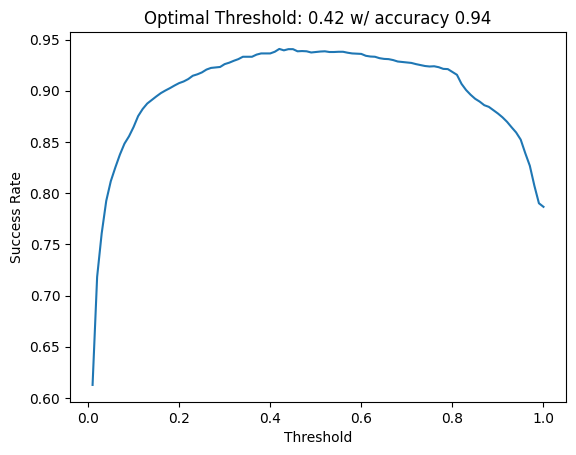

In [62]:
score = []
thresholds = np.arange(1, 101, 1)/100
score = [np.sum((preds[:, 0] >= t).astype('int') == val_labels) / len(val_labels) for t in thresholds]
plt.plot(thresholds, score)
plt.ylabel('Success Rate')
plt.xlabel('Threshold')
plt.title(f"Optimal Threshold: {thresholds[np.argmax(score)]:.2f} w/ accuracy {score[np.argmax(score)]:.2f}")
plt.show()


In [63]:
threshold = 0.42
dates = set([os.path.basename(f).split('2022-')[1][:5] for f in glob.glob(os.path.join(data_dir, 'train', '*.tif'))])
dates = [f"2022-{d}" for d in dates]

model_path = os.path.join(WORK_DIR, f'models/{model_name}.h5')
with open(model_path.split('.h5')[0] + '_config.txt', 'w') as f:
    f.write('Training data dates:\n')
    [f.write('\t' + date + '\n') for date in dates]
    f.write('\n\nAugmentation Parameters:\n')
    for k, v in zip(augmentation_parameters.keys(), augmentation_parameters.values()):
        f.write(f"\t{k}: {v}\n")
    f.write(f"\nBatch Size: {batch_size}")
    f.write(f"\nTraining Epochs: {len(train_accuracy)}")
    f.write(f'\n\nClassification Report at {threshold}\n')
    f.write(classification_report(val_labels, preds > threshold, target_names=['No Oil', 'Oil']))
   

In [57]:
model_name

'224px_v1.3maracaibo_2025-08-18'

In [12]:
steps = math.ceil(num_val_samples / batch_size)


Plot images that the model classifies incorrectly. Can be useful to evaluate model bias.

In [ ]:
threshold = 0.94
test_model = model
val_images = x_test
val_labels = y_test
test_labels = val_labels
test_preds = test_model.predict(val_images)
for index, (label, pred, img) in enumerate(zip(test_labels, test_preds, val_images)):
    pred = pred[0]
    if pred < threshold:
        binary_pred = 0
    else:
        binary_pred = 1
    if label != binary_pred:
        rgb = (img[:,:,3:0:-1] * 10000 / 3000)
        fig = plt.figure(figsize=(2,2), facecolor=(1,1,1), dpi=150)
        plt.imshow(np.clip(rgb, 0, 1))
        plt.title(f"label: {label} - pred: {pred:.2f}")
        plt.axis('off')
        plt.show()